# Predict whether the movie or the TV show is going to be nominated or win an award

Assuming the role of lead data scientist in 2005, you're presented with a challenge: Amazon Studios wants to produce award-winning films and, therefore, focus the budget on projects with the best chance of winning those awards. Using the actual dataset from IMDb, an Amazon subsidiary, you begin your investigation by looking for movies made between 1990 and 2005.

The IMDb dataset is a feature-rich, comprehensive listing of all films released during that time period; it includes critical data such as cast and crew, synopsis, and other production data. Much of this data is published on the public IMDb.com site, while other features are embargoed for studio analytics.

Your task is to predict which movies will most likely be nominated for an award during the upcoming 2005 awards season by building an awards analysis prediction model. 

This is a notebook in which we read in fields of data from the IMDB database and build a model to make predictions of whether the movie is "nominated" or "Winner".

This data set is being provided to you by permission of IMDb and is subject to the terms of the AWS Digital Training Agreement (available at https://aws.amazon.com/training/digital-training-agreement).  You are expressly prohibited from copying, modifying, selling, exporting or using this data set in any way other than for the purpose of completing this lab.

## Importing the required libraries 

For this exercise, you will use the scikit-learn library to preprocess the models and make predictions. 
(You can add any other libraries that you need below as well.)

In [1]:
# Importing libs into the python environment. These functions will be referenced later in the notebook code.

from __future__ import print_function
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import gzip
import numpy as np
import seaborn as sns
import itertools
from IPython.display import Markdown, display
from mpl_toolkits.mplot3d import axes3d, Axes3D  # <-- Note the capitalization!
%matplotlib inline

sns.set()


# Modules from scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.preprocessing import StandardScaler


## Thinking about your Data

The IMDB database contains a huge amount of information, so it's important to consider what kinds of information are relevant to your prediction. Here's the schema you're using.


<img src="Data-Schema-Capstone.png">

## Cleaning and Visualizing Your Data

Replace **<LabBucketName\>** with the resource name that was provided with your lab account.

In [3]:
import boto3
import botocore 
bucket = 'mlu-data-661217393343-us-west-2-qls-11878984-849aa8dfe38206ca' # Update this to the bucket that was created in your lab account as part of this enviroment.
prefix = 'data/'
 
s3 = boto3.resource('s3') 


Raw data files are in an S3 bucket in your AWS lab account. Six tables will be used (`title_genres`, `title_ratings`, `title_display`, `award_noms`, `title_awards`, `title_releases`). Raw tab-separated value files will be downloaded into your Amazon Sagemaker instance, and imported into a DataFrame, where it's easier to work  with the structured data. Raw files do not contain row headers, and thus labels are being assiged at import.

In [5]:
def download_and_display_file(filename,names, title):
    s3.Bucket(bucket).download_file(filename, filename)
    user_info = pd.read_csv(filename, sep='\t', encoding= 'latin1', names = names)
    display(Markdown("**" + title +" Table** \n"))
    display(user_info.head(5))
    return user_info

user_info_genres = download_and_display_file('title_genres.tsv', ['titleId','genres'], 'Genres')
user_info_ratings = download_and_display_file('title_ratings.tsv', ["titleId","rating","ratingCount","topRank","bottomRank","topRankTV"], 'Rating')
user_info_display = download_and_display_file('title_display.tsv', ["titleId","title","year","adult","runtimeMinutes","imageUri","imageId","type","originalTitle"], 'Display')
user_info_noms = download_and_display_file('award_noms.tsv', ["awardId","eventId","event","eventEditionId","award","category","year"], 'Nomination')
user_info_awards = download_and_display_file('title_awards.tsv', ["titleId","awardId","winner"], 'Awards')
user_info_releases = download_and_display_file('title_releases.tsv', ["titleId","ordering","date","region","premiere","wide","premiereType","festival","attributes"], 'Releases')


**Genres Table** 


,titleId,genres
0,tt0015724,DramaMysteryRomanceThriller
1,tt0035423,ComedyFantasyRomance
2,tt0059900,DramaFantasy
3,tt0064994,ComedyDramaRomance
4,tt0065188,Drama


**Rating Table** 


,titleId,rating,ratingCount,topRank,bottomRank,topRankTV
0,tt0015724,6.2,19,\N,\N,\N
1,tt0035423,6.4,72032,3107,2579,\N
2,tt0059900,6.8,21,\N,\N,\N
3,tt0064994,7.6,1387,\N,\N,\N
4,tt0065188,6.7,19,\N,\N,\N


**Display Table** 


,titleId,title,year,adult,runtimeMinutes,imageUri,imageId,type,originalTitle
0,tt0015724,Dama de noche,1993,0,102,https://m.media-amazon.com/images/M/MV5BODY4ND...,rm615620352,movie,Dama de noche
1,tt0035423,Kate & Leopold,2001,0,118,https://m.media-amazon.com/images/M/MV5BNmNlN2...,rm2171875072,movie,Kate & Leopold
2,tt0059900,"Wenn du groÃ bist, lieber Adam",1990,0,78,https://m.media-amazon.com/images/M/MV5BMTYzOT...,rm2847710208,movie,"Wenn du groÃ bist, lieber Adam"
3,tt0064994,Larks on a String,1990,0,94,https://m.media-amazon.com/images/M/MV5BMTE5OT...,rm905747712,movie,SkrivÃ¡nci na niti
4,tt0065188,"Vojtech, receny sirotek",1990,0,80,\N,\N,movie,"Vojtech, receny sirotek"


**Nomination Table** 


,awardId,eventId,event,eventEditionId,award,category,year
0,an0015278,ev0000206,Daytime Emmy Awards,ee0021710,Daytime Emmy,Outstanding Drama Series,1990
1,an0015279,ev0000206,Daytime Emmy Awards,ee0021710,Daytime Emmy,Outstanding Drama Series,1990
2,an0015280,ev0000206,Daytime Emmy Awards,ee0021710,Daytime Emmy,Outstanding Drama Series,1990
3,an0015281,ev0000206,Daytime Emmy Awards,ee0021710,Daytime Emmy,Outstanding Drama Series,1990
4,an0015283,ev0000206,Daytime Emmy Awards,ee0021710,Daytime Emmy,Outstanding Animated Program,1990


**Awards Table** 


,titleId,awardId,winner
0,tt0015724,an0322954,0
1,tt0035423,an0033807,0
2,tt0035423,an0055446,0
3,tt0035423,an0063409,0
4,tt0035423,an0063447,1


**Releases Table** 


,titleId,ordering,date,region,premiere,wide,premiereType,festival,attributes
0,tt0015724,1,1993-03-18,MX,0,1,\N,\N,\N
1,tt0015724,2,0000-00-00,US,0,0,\N,Chicago International Film Festival,\N
2,tt0035423,10,2002-02-14,NL,0,1,\N,\N,\N
3,tt0035423,11,2002-02-22,TR,0,1,\N,\N,\N
4,tt0035423,1,2001-12-11,US,1,0,\N,\N,"Los Angeles, California"



The data in table format (.tsv) are consumed into a Pandas DataFrame for data preprocessing. The data is split between six different files or DataFrames. Merge the data to obtain a unified DataFrame which will be used to do further data exploration, data engineering, visualization, and model building. You will use the built-in `merge` function in pandas to merge the DataFrames together. `TitleId` is a uniqueId that is assigned to each movie title in this dataset. A set of inner joins between `title_ratings`, `title_genres`, `title_display`, `title_releases` will merge all these tables together. 

In [8]:
df_first_merge = pd.merge(user_info_genres, user_info_ratings, on='titleId', how='inner')
df_second_merge = pd.merge(df_first_merge, user_info_display, on='titleId', how='inner')
df_third_merge = pd.merge(df_second_merge, user_info_releases, on='titleId', how='inner')

In [10]:
df_third_merge.head()

,titleId,genres,rating,ratingCount,topRank,bottomRank,topRankTV,title,year,adult,...,type,originalTitle,ordering,date,region,premiere,wide,premiereType,festival,attributes
0,tt0015724,DramaMysteryRomanceThriller,6.2,19,\N,\N,\N,Dama de noche,1993,0,...,movie,Dama de noche,1,1993-03-18,MX,0,1,\N,\N,\N
1,tt0015724,DramaMysteryRomanceThriller,6.2,19,\N,\N,\N,Dama de noche,1993,0,...,movie,Dama de noche,2,0000-00-00,US,0,0,\N,Chicago International Film Festival,\N
2,tt0035423,ComedyFantasyRomance,6.4,72032,3107,2579,\N,Kate & Leopold,2001,0,...,movie,Kate & Leopold,10,2002-02-14,NL,0,1,\N,\N,\N
3,tt0035423,ComedyFantasyRomance,6.4,72032,3107,2579,\N,Kate & Leopold,2001,0,...,movie,Kate & Leopold,11,2002-02-22,TR,0,1,\N,\N,\N
4,tt0035423,ComedyFantasyRomance,6.4,72032,3107,2579,\N,Kate & Leopold,2001,0,...,movie,Kate & Leopold,1,2001-12-11,US,1,0,\N,\N,"Los Angeles, California"


Duplicate titleId is dropped, prior to doing a outer join with (title_awards) table. The resulted duplicates in the DataFrame are dropped, as well as a few of the data columns. The IMDB dataset is huge with hundreds of fields - only the relevant fields are picked here that could possibly affect the model output.  After reading in these relevant tables, only the relevant fields are retained and the rest of them are dropped as shown below.

In [11]:
df_third_merge = df_third_merge.drop_duplicates(['titleId'])
df_fourth_merge = pd.merge(df_third_merge,user_info_awards,on='titleId', how='outer' )
    
df = df_fourth_merge.drop_duplicates(['titleId'])
df = df.drop(['imageUri','topRank','bottomRank','topRankTV','ordering','premiereType','festival' ], axis=1)

The resulted DataFrame is serialized and written to a flat file called the Pickle using the **Pickle** library. This file is then saved into the Amazon S3 bucket for later re-use of the data. You can generate a Pickle file using `pickle.dump` and save the raw datafile in that object and upload the file to the lab S3 bucket.

In [12]:
with open('df_pickle_nonoms_new.pkl', 'wb') as handle:
    pickle.dump(df, handle, protocol=pickle.HIGHEST_PROTOCOL)
s3.Bucket(bucket).upload_file('df_pickle_nonoms_new.pkl','data/df_pickle_nonoms_new.pkl')

Review the top 30 rows of optimized table.

In [13]:
df.head(30)

,titleId,genres,rating,ratingCount,title,year,adult,runtimeMinutes,imageId,type,originalTitle,date,region,premiere,wide,attributes,awardId,winner
0,tt0015724,DramaMysteryRomanceThriller,6.2,19.0,Dama de noche,1993,0.0,102,rm615620352,movie,Dama de noche,1993-03-18,MX,0.0,1.0,\N,an0322954,0.0
1,tt0035423,ComedyFantasyRomance,6.4,72032.0,Kate & Leopold,2001,0.0,118,rm2171875072,movie,Kate & Leopold,2002-02-14,NL,0.0,1.0,\N,an0033807,0.0
7,tt0059900,DramaFantasy,6.8,21.0,"Wenn du groÃ bist, lieber Adam",1990,0.0,78,rm2847710208,movie,"Wenn du groÃ bist, lieber Adam",1990-02-18,XWG,0.0,0.0,\N,an0058812,1.0
9,tt0064994,ComedyDramaRomance,7.6,1387.0,Larks on a String,1990,0.0,94,rm905747712,movie,SkrivÃ¡nci na niti,1990-11-16,DK,0.0,1.0,\N,an0058789,1.0
12,tt0065188,Drama,6.7,19.0,"Vojtech, receny sirotek",1990,0.0,80,\N,movie,"Vojtech, receny sirotek",0000-00-00,CSHH,0.0,1.0,\N,an0253498,1.0
14,tt0066498,DramaThriller,7.9,1995.0,The Ear,1990,0.0,94,rm3166657792,movie,Ucho,2003-04-30,HR,0.0,0.0,Split,an0044440,0.0
16,tt0077432,ActionDrama,6.7,6.0,Dip huet kei bing,1991,0.0,\N,rm4261125120,movie,Dip huet kei bing,1991-10-19,HK,0.0,1.0,\N,NaN,NaN
17,tt0081145,ComedyCrimeDramaFamily,5.3,204.0,Me and the Kid,1993,0.0,94,rm467442944,movie,Me and the Kid,1993-10-22,US,0.0,1.0,\N,NaN,NaN
18,tt0081721,DramaFamilyFantasy,6.5,276.0,Vincent and Me,1990,0.0,100,rm1878772224,movie,Vincent et moi,1990-12-13,CA,0.0,1.0,\N,an0015473,1.0
25,tt0084015,Drama,7.3,39.0,Goodbye Paradise,1991,0.0,101,rm2081463296,movie,Goodbye Paradise,0000-00-00,US,0.0,0.0,\N,NaN,NaN


Run some basic pandas descriptive statistics on your new DataFrame. 

`df.info()` prints more information about your DataFrame. This includes information such as index dtype, column dtypes, non-null values and memory usage. `df.describe()` generates descriptive statistics such as mean, median, mode etc.

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52138 entries, 0 to 141540
Data columns (total 18 columns):
titleId           52138 non-null object
genres            47781 non-null object
rating            47781 non-null float64
ratingCount       47781 non-null float64
title             47781 non-null object
year              47781 non-null object
adult             47781 non-null float64
runtimeMinutes    47781 non-null object
imageId           47781 non-null object
type              47781 non-null object
originalTitle     47781 non-null object
date              47781 non-null object
region            47781 non-null object
premiere          47781 non-null float64
wide              47781 non-null float64
attributes        47781 non-null object
awardId           21364 non-null object
winner            21364 non-null float64
dtypes: float64(6), object(12)
memory usage: 7.6+ MB


In [ ]:
df.describe()

Load the Pickle file into a Pandas Dataframe and drop some of the irrelevant features.

In [16]:
s3.Bucket(bucket).download_file('data/df_pickle_nonoms_new.pkl', 'df_pickle_nonoms_new.pkl')
df = pickle.load(open('df_pickle_nonoms_new.pkl', 'rb'))
df = df[df.type == 'movie']
df = df.drop(['imageId', 'originalTitle', 'awardId', 'attributes' ], axis=1)

The resulted data requires normalization. The source data has `\N` as the value if the run time of a movie is not known. This null value will cause issues when trying to plot the data. You will change any `\N` for runtime to a zero. 

Similarly, if the film released year is not known, value is set to `\N`. You will change any `\N` for year to a zero in the cell below.

Below will display tables with runtimeMinutes `\N`.

In [17]:
df[df.runtimeMinutes == r'\N'].head()

,titleId,genres,rating,ratingCount,title,year,adult,runtimeMinutes,type,date,region,premiere,wide,winner
16,tt0077432,ActionDrama,6.7,6.0,Dip huet kei bing,1991,0.0,\N,movie,1991-10-19,HK,0.0,1.0,NaN
61,tt0094004,ActionThrillerWar,5.7,60.0,Soldier of Fortune,1990,0.0,\N,movie,1990-04-28,JP,0.0,1.0,NaN
62,tt0094045,Documentary,7.0,8.0,Storme: Lady of the Jewel Box,1991,0.0,\N,movie,1991-05-07,US,0.0,0.0,NaN
88,tt0095335,Drama,5.5,6.0,The Vengeance,1995,0.0,\N,movie,1995-02-06,HK,0.0,1.0,NaN
103,tt0096174,Drama,6.9,70.0,Stela,1990,0.0,\N,movie,1990-05-29,XYU,0.0,1.0,NaN


Below will display tables with year `\N`.

In [18]:
df[df.year == r'\N'].head()

,titleId,genres,rating,ratingCount,title,year,adult,runtimeMinutes,type,date,region,premiere,wide,winner
130194,tt3329456,CrimeDramaRomance,5.6,58.0,Heartlock,\N,0.0,96,movie,2018-07-24,GB,1.0,0.0,NaN
130718,tt4630466,Horror,8.4,22.0,Virgin Cheerleaders in Chains,\N,0.0,\N,movie,2018-08-09,BR,0.0,1.0,NaN
130933,tt5130442,CrimeDrama,6.0,34.0,22 Chaser,\N,0.0,90,movie,2018-07-01,CA,0.0,1.0,NaN
131368,tt5867226,ActionThriller,4.5,199.0,Silencer,\N,0.0,88,movie,2018-09-04,US,0.0,1.0,1.0
131476,tt6149820,Drama,7.2,18.0,Zoo,\N,0.0,100,movie,2018-07-01,IN,0.0,1.0,NaN


In [19]:
for i, mins in df['runtimeMinutes'].iteritems():
    if mins == r'\N':
        better_name = '0'
        df.loc[[i],['runtimeMinutes']] = better_name

for i, year in df['year'].iteritems():
    if year == r'\N':
        better_name = '0'
        df.loc[[i],['year']] = better_name


A separate column called `nomination_winner` is added to the DataFrame. If winner column has either `0.0` or `1.0` value, it is assumed that the title has been nominated. Else, the title has not been nominated.

In [20]:
df['winner'].iteritems() 

In [21]:
df['nomination_winner'] = 0
for i, winner in df['winner'].iteritems():
    if winner == (0.0):
        better_name = 1
        df.loc[[i],['nomination_winner']] = better_name
    if winner == (1.0):
        better_name = 1
        df.loc[[i],['nomination_winner']] = better_name

 You will also use the `fillna` function to fill the missing values in the `year` column and `runtimeMinutes` column.

In [23]:
df.runtimeMinutes = df.runtimeMinutes.astype(float).fillna(0.0)
df.year = df.year.astype(int).fillna(0.0)

In [26]:
df[df['titleId']=='tt5130442']

,titleId,genres,rating,ratingCount,title,year,adult,runtimeMinutes,type,date,region,premiere,wide,winner,nomination_winner
130933,tt5130442,CrimeDrama,6.0,34.0,22 Chaser,0,0.0,90.0,movie,2018-07-01,CA,0.0,1.0,NaN,0


Some titles that are included into your dataset have run times that don't seem to fit. You are going to limit this data with a runtime of longer then 1 hour (60 minutes) and no greater then 12 hours (720 minutes). YOU are also going to focus on movies with a `reviewCount` of less than 20,000.

Below, you will see sample data with `runtimesMinutes` of less than 60 minutes.

In [27]:
df[(df.runtimeMinutes) < 60].head()

,titleId,genres,rating,ratingCount,title,year,adult,runtimeMinutes,type,date,region,premiere,wide,winner,nomination_winner
16,tt0077432,ActionDrama,6.7,6.0,Dip huet kei bing,1991,0.0,0.0,movie,1991-10-19,HK,0.0,1.0,NaN,0
61,tt0094004,ActionThrillerWar,5.7,60.0,Soldier of Fortune,1990,0.0,0.0,movie,1990-04-28,JP,0.0,1.0,NaN,0
62,tt0094045,Documentary,7.0,8.0,Storme: Lady of the Jewel Box,1991,0.0,0.0,movie,1991-05-07,US,0.0,0.0,NaN,0
88,tt0095335,Drama,5.5,6.0,The Vengeance,1995,0.0,0.0,movie,1995-02-06,HK,0.0,1.0,NaN,0
103,tt0096174,Drama,6.9,70.0,Stela,1990,0.0,0.0,movie,1990-05-29,XYU,0.0,1.0,NaN,0


Below, you will see sample data with `runtimesMinutes` of more than 720 minutes.

In [28]:
df[(df.runtimeMinutes) > 720].head()

,titleId,genres,rating,ratingCount,title,year,adult,runtimeMinutes,type,date,region,premiere,wide,winner,nomination_winner
127994,tt1447786,Documentary,8.2,8.0,Grandmother Martha,1996,0.0,1452.0,movie,0000-00-00,US,0.0,1.0,NaN,0
129583,tt2355497,Documentary,7.1,9.0,Beijing 2003,2004,0.0,9000.0,movie,0000-00-00,CN,0.0,1.0,NaN,0


In [29]:
df = df[(df.runtimeMinutes) > 60]
df = df[(df.runtimeMinutes) < 720]
df = df[(df.ratingCount) < 20000]

**Review top 30 columns of optimized data.**

In [30]:
df.head(30)

,titleId,genres,rating,ratingCount,title,year,adult,runtimeMinutes,type,date,region,premiere,wide,winner,nomination_winner
0,tt0015724,DramaMysteryRomanceThriller,6.2,19.0,Dama de noche,1993,0.0,102.0,movie,1993-03-18,MX,0.0,1.0,0.0,1
7,tt0059900,DramaFantasy,6.8,21.0,"Wenn du groÃ bist, lieber Adam",1990,0.0,78.0,movie,1990-02-18,XWG,0.0,0.0,1.0,1
9,tt0064994,ComedyDramaRomance,7.6,1387.0,Larks on a String,1990,0.0,94.0,movie,1990-11-16,DK,0.0,1.0,1.0,1
12,tt0065188,Drama,6.7,19.0,"Vojtech, receny sirotek",1990,0.0,80.0,movie,0000-00-00,CSHH,0.0,1.0,1.0,1
14,tt0066498,DramaThriller,7.9,1995.0,The Ear,1990,0.0,94.0,movie,2003-04-30,HR,0.0,0.0,0.0,1
17,tt0081145,ComedyCrimeDramaFamily,5.3,204.0,Me and the Kid,1993,0.0,94.0,movie,1993-10-22,US,0.0,1.0,NaN,0
18,tt0081721,DramaFamilyFantasy,6.5,276.0,Vincent and Me,1990,0.0,100.0,movie,1990-12-13,CA,0.0,1.0,1.0,1
25,tt0084015,Drama,7.3,39.0,Goodbye Paradise,1991,0.0,101.0,movie,0000-00-00,US,0.0,0.0,NaN,0
26,tt0084548,CrimeDramaThriller,8.1,2549.0,Interrogation,1990,0.0,118.0,movie,1991-03-22,HU,0.0,1.0,1.0,1
36,tt0084551,ComedyDramaFantasyHorrorRomance,5.3,9.0,The Buddhist Spell,1993,0.0,91.0,movie,0000-00-00,TW,0.0,1.0,NaN,0


In [31]:
print('='*50)
df.info()
print('='*50)
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29373 entries, 0 to 133838
Data columns (total 15 columns):
titleId              29373 non-null object
genres               29373 non-null object
rating               29373 non-null float64
ratingCount          29373 non-null float64
title                29373 non-null object
year                 29373 non-null int64
adult                29373 non-null float64
runtimeMinutes       29373 non-null float64
type                 29373 non-null object
date                 29373 non-null object
region               29373 non-null object
premiere             29373 non-null float64
wide                 29373 non-null float64
winner               13444 non-null float64
nomination_winner    29373 non-null int64
dtypes: float64(7), int64(2), object(6)
memory usage: 3.6+ MB


,rating,ratingCount,year,adult,runtimeMinutes,premiere,wide,winner,nomination_winner
count,29373.000000,29373.000000,29373.000000,29373.0,29373.000000,29373.000000,29373.000000,13444.000000,29373.000000
mean,6.084789,1030.848637,1998.613999,0.0,99.331461,0.130732,0.499506,0.546935,0.457699
std,1.286407,2631.342870,26.487097,0.0,22.082184,0.337113,0.500008,0.497811,0.498216
min,1.100000,5.000000,0.000000,0.0,61.000000,0.000000,0.000000,0.000000,0.000000
25%,5.300000,33.000000,1995.000000,0.0,88.000000,0.000000,0.000000,0.000000,0.000000
50%,6.200000,137.000000,2000.000000,0.0,95.000000,0.000000,0.000000,1.000000,0.000000
75%,7.000000,579.000000,2003.000000,0.0,105.000000,0.000000,1.000000,1.000000,1.000000
max,9.700000,19999.000000,2005.000000,0.0,700.000000,1.000000,1.000000,1.000000,1.000000


**Below, you are saving dataframe for year 2005 as df_2005 for future use.**

In [32]:
df_2005 = df[(df.year) == 2005]
df_2005.head()

,titleId,genres,rating,ratingCount,title,year,adult,runtimeMinutes,type,date,region,premiere,wide,winner,nomination_winner
39,tt0088751,ComedyHorrorSci-Fi,5.8,178.0,The Naked Monster,2005,0.0,100.0,movie,2005-04-22,US,1.0,0.0,NaN,0
27448,tt0118141,Drama,5.9,806.0,What Is It?,2005,0.0,72.0,movie,2005-01-27,US,0.0,1.0,1.0,1
42018,tt0148403,Documentary,4.9,50.0,"Life, Love & Celluloid",2005,0.0,90.0,movie,2005-07-30,PL,0.0,0.0,NaN,0
44097,tt0160706,CrimeDramaThriller,5.7,852.0,The Prodigy,2005,0.0,120.0,movie,2007-07-27,FI,1.0,0.0,NaN,0
49561,tt0179803,Comedy,5.6,116.0,Angels with Angles,2005,0.0,87.0,movie,2005-12-16,US,0.0,1.0,NaN,0


## Feature Selection and Feature Engineering
<a id='feature selection'></a>

**Feature Selection Box:** The toggle switches for various features and settings are below. A value of 0 disables the feature, and a value of 1 enables the feature.

In [33]:
# Selection of different features

feature_winner = 0          # Select this feature to make prediction on award winner. 
                            # Disable this feautre to make prediction on nomination winners.
    
feature_pca_2D = 0          # Select this feature to perform Principal Component Analysis of 2 components.
feature_pca_3D = 1          # Select this feature to perform Principal Component Analysis of 3 components.

feature_premiere = 0        # Select this feature to limit analysis on limited premiered movies.
feature_wide = 0            # Select this feature to limit analysis on world wide premiered movies.
feature_premiere_wide = 1   # Select this feature to include analysis on both limited and wide premiered movies.


# Normalize features
normalize_flag = 0

#Enable plotting
plot_flag = 1                 

#Feaure Selection 
US_flag = 1                 # Select this feature to limit analysis on US based movies.

#Model Selection flags
LR_flag = 1
DT_flag = 1
RF_flag = 1
GB_flag = 1
NN_flag = 1
SVM_flag = 1


**Clean up and constrain the data:** 
- Explore by limiting your dta to only **US** features. 
- Explore by choosing whether to use **nomination** or **winner** to be output target.

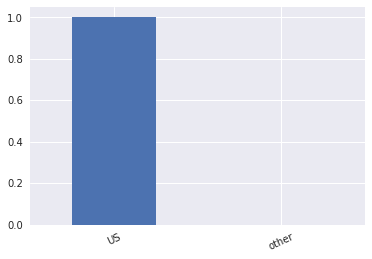

In [37]:
#plt.figure(figsize=(12,6))

if plot_flag: 
    prob = df.region.value_counts(normalize=True)
    threshold = 0.02
    mask = prob > threshold
    tail_prob = prob.loc[~mask].sum()
    prob = prob.loc[mask]
    prob['other'] = tail_prob
    prob.plot(kind='bar')
    plt.xticks(rotation=25)
    plt.show()
    plt.close()



if US_flag:
    df = df[ (df.region) == 'US']


# This flag is set if "winner" is chosen as output label

if feature_winner:
    df = df[(df.nomination_winner) == 1]

    for i, winner in df['winner'].iteritems():
        if winner == (0.0):
            better_name = 0
            df.loc[[i],['nomination_winner']] = better_name
        if winner == (1.0):
            better_name = 1


You are going to be graphing the features to help better understand how features might relate to each other. Below is defining the function to be called later after the data has been imported. 

In [38]:
#plot Confusion Matrix function

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    plt.close()


# end Confusion Matrix function


# ROC Curve Plotting function

def plot_roc_curve(fpr,tpr):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
             label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.close()

#end ROC plotting function


# Precision Recall (PR) function

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.show( )
    plt.close()

#end PR function
 

Below you will plot histograms of different features such as `rating`, `ratingCount`. Review the effect of `premier` flag on the output. Also look at the effects or cross correlation between the different features as well as the output.  You see that the `ratingCount` has the maximum effect on the output `nomination_winner` (could be `nomination` or `winner`). 

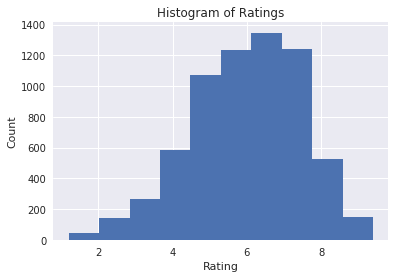

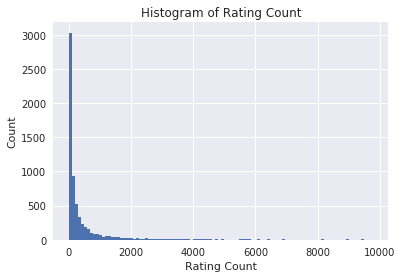

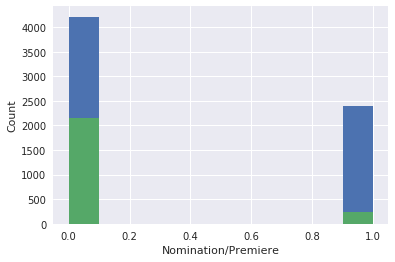

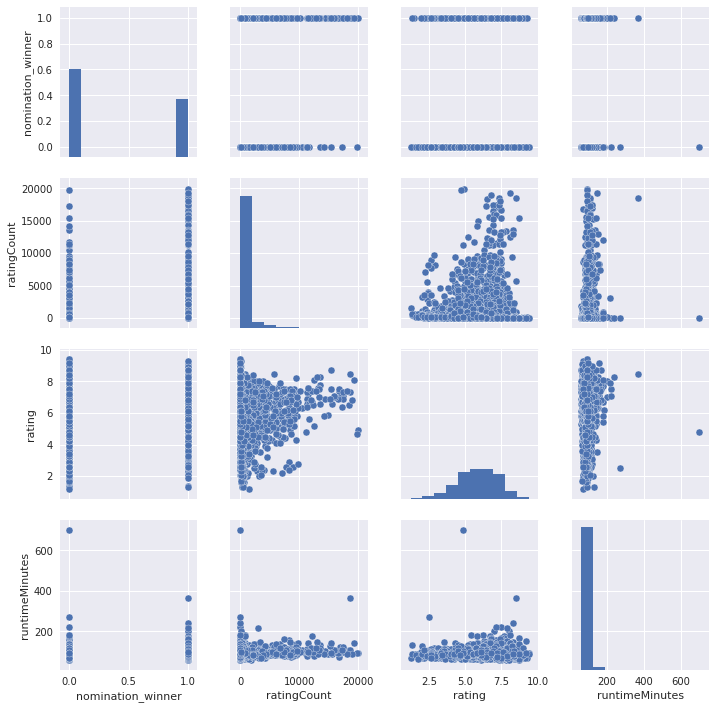

In [39]:

# Plot rating vs rating count & Histogram of Rating

if plot_flag:
    
    df['rating'].hist()
    plt.title('Histogram of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()
    plt.close()
    
    
    df_plot = df[(df.ratingCount) < 10000]
    df_plot['ratingCount'].hist(bins=100)
    plt.title('Histogram of Rating Count')
    plt.xlabel('Rating Count')
    plt.ylabel('Count')
    plt.show()
    plt.close()

    plot_hist1 = df[(df.nomination_winner) == 1]
    plot_hist0 = df[(df.nomination_winner) == 0]
    plt.hist(df.nomination_winner)
    plt.hist(plot_hist1.premiere)
    plt.xlabel('Nomination/Premiere')
    plt.ylabel('Count')
    plt.show()
    plt.close()

 
    #Plotting correlation  

    
    sns.pairplot(df[['nomination_winner', 'ratingCount','rating', 'runtimeMinutes' ]].head(5000));
    plt.show()
    plt.close()


**Experiment with different features and look at the roc scores in each model.** Run steps through **Feature Selection Box.**

<a href='#feature selection'>**Link to the feature selection box**</a>

In [40]:

if feature_premiere_wide:
    X_train = df[['rating', 'ratingCount', 'runtimeMinutes','premiere','wide']]
elif feature_premiere:
    X_train = df[['rating', 'ratingCount', 'runtimeMinutes','premiere' ]]
elif feature_wide:
    X_train = df[['rating', 'ratingCount',  'runtimeMinutes' ,'wide']]
else :
    X_train = df[['rating', 'ratingCount',  'runtimeMinutes']]


Y_train = df['nomination_winner']

if normalize_flag:
    X_train=(StandardScaler().fit_transform(X_train ))


Below you will Experiment with **Principal Component Analysis** and reduce the Feature set to three main components.

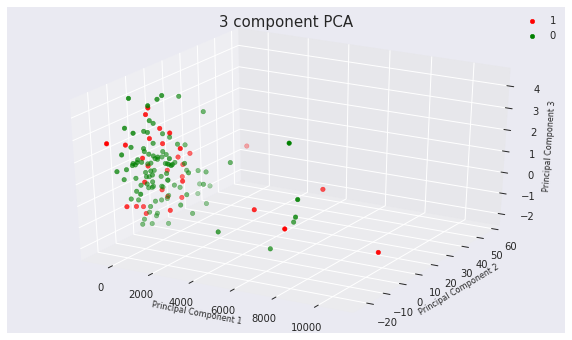

In [41]:
#PCA


if feature_pca_3D:
    pca = decomposition.PCA(n_components=3)
    
     
    principalComponents = pca.fit_transform(X_train )

    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2','principal component 3'])
    
    
    finalDf = pd.concat([principalDf, Y_train], axis = 1)
    finalDf = finalDf.head(2000)
    targets = [1, 0 ]
    colors = ['r', 'g' ]
     
    my_dpi = 96
    
    fig = plt.figure(figsize=(10,6))
    
    ax = fig.add_subplot(111,projection='3d' )
    ax.set_xlabel('Principal Component 1', fontsize = 8)
    ax.set_ylabel('Principal Component 2', fontsize = 8)
    ax.set_zlabel('Principal Component 3', fontsize = 8)
    ax.set_title('3 component PCA', fontsize = 15)
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['nomination_winner'] == target
        
        
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                    , finalDf.loc[indicesToKeep, 'principal component 2']
                   ,  finalDf.loc[indicesToKeep, 'principal component 3']
                    , c = color,  linewidth=0.5)
        
    ax.legend(targets)
    #ax.grid() 
    plt.show()
    plt.close()
    
    X_train_pca = pca.transform(X_train)
    
    # In order to use PCA_3D for testing, uncomment below line and run this cell.
    #X_train = X_train_pca 
    
elif feature_pca_2D:
    
     
    pca = decomposition.PCA(n_components=2)
    principalComponents = pca.fit_transform(X_train )

    
    
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['principal component 1', 'principal component 2'] )
    
    finalDf = pd.concat([principalDf, Y_train], axis = 1)
    finalDf = finalDf.head(50)
    
    targets = [1, 0 ]
    colors = ['r', 'g' ]
     
    my_dpi = 96
  
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111 )

    ax.set_xlabel('Principal Component 1', fontsize = 8)
    ax.set_ylabel('Principal Component 2', fontsize = 8)

    ax.set_title('2 component PCA', fontsize = 15)
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf['nomination_winner'] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
                   , finalDf.loc[indicesToKeep, 'principal component 2']               
                    , c = color,  linewidth=0.5)

    ax.legend(targets)
    #ax.grid() 
    plt.show()
    plt.close()
    
    X_train_pca = pca.transform(X_train)
    
    # In order to use PCA_2D for testing, uncomment below line and run this cell.
    #X_train = X_train_pca 
    
  

#PCA ends

You will notice during the analysis that the "nomination/winner" 3D points (Red dots) are within the clusters of the non "nomination/winner" 3D points (Green dots). This suggests it is hard to classify your data in 3D model using PCA analysis.

Split the dataset into training and test data sets.

In [42]:

x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=0)
 

## Algorithm Comparison and Selection

Now you will build models using Logistic Regression, Support Vector Machine (SVM), Random Forest (RF), Decision Tree (DT), Gradient Boosting (GB) and Multi-Layer Perceptron (NN) classification schemes. The various scores such as Precision, Recall, ROC, F1, Accuracy are measured. You will also plot the ROC curves for the different models. 

LR Accuracy 0.6702964307320024
roc score 0.5790262172284644
Classification Report
              precision    recall  f1-score   support

           0       0.69      0.89      0.78      1068
           1       0.57      0.27      0.36       585

   micro avg       0.67      0.67      0.67      1653
   macro avg       0.63      0.58      0.57      1653
weighted avg       0.65      0.67      0.63      1653

Confusion matrix, without normalization
[[952 116]
 [429 156]]


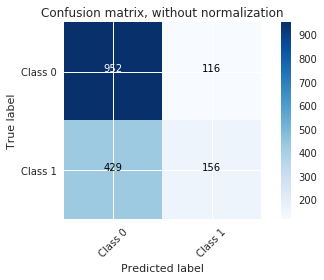

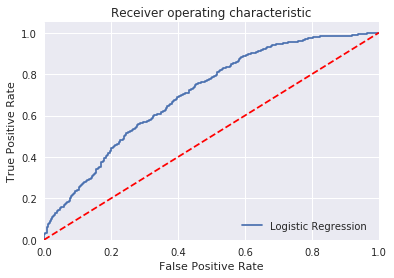

In [43]:
if LR_flag:

# Logistic Regression Model

    logisticRegr = LogisticRegression(random_state=0, solver='lbfgs',
                        multi_class='multinomial', max_iter=1000)
    logisticRegr.fit(x_train, y_train)
    y_test_pred_LR = cross_val_predict(logisticRegr, x_test, y_test, cv=3)
    score = logisticRegr.score(x_test, y_test)
    y_test_pred = y_test_pred_LR
    print("LR Accuracy",accuracy_score(y_test, y_test_pred))
    roc = roc_auc_score(y_test, y_test_pred)
    print("roc score", roc)
    print("Classification Report")
    print("="*50)
    LR_CR = classification_report(y_test, y_test_pred)
    print(classification_report(y_test, y_test_pred))
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    # Compute ROC curve and ROC area
    #fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
  

    
    logit_roc_auc = roc_auc_score(y_test_pred, logisticRegr.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, logisticRegr.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression ' )
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
     
    plt.show()


SVM Accuracy 0.5680580762250453
roc score 0.514208201286853
Classification Report
              precision    recall  f1-score   support

           0       0.66      0.70      0.68      1068
           1       0.37      0.33      0.35       585

   micro avg       0.57      0.57      0.57      1653
   macro avg       0.52      0.51      0.51      1653
weighted avg       0.56      0.57      0.56      1653

Confusion matrix, without normalization
[[746 322]
 [392 193]]


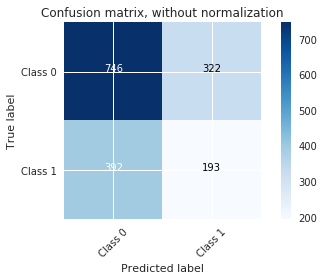

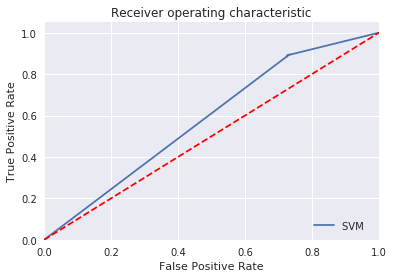

In [49]:

if SVM_flag:
    # SVM Model

    sgd_clf = SGDClassifier(random_state=0, loss="log", max_iter=1000, tol=3 )
    sgd_clf.fit(x_train, y_train)
    cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")
    y_test_pred_SVC = cross_val_predict(sgd_clf, x_test, y_test, cv=3)
    predictions = sgd_clf.predict(x_test)
    score = sgd_clf.score(x_test, y_test)
    y_test_pred = y_test_pred_SVC
    print("SVM Accuracy",accuracy_score(y_test, y_test_pred))
    roc = roc_auc_score(y_test, y_test_pred_SVC)
    print("roc score", roc)
    SVM_CR = classification_report(y_test, y_test_pred)
    print("Classification Report")
    print("="*50)
    print(SVM_CR)
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
     
  
    
    
    roc_auc = roc_auc_score(y_test_pred, sgd_clf.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, sgd_clf.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='SVM  ' )
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
     
    plt.show()



DT Accuracy 0.6297640653357531
roc score 0.5859262460386057
Classification Report
              precision    recall  f1-score   support

           0       0.70      0.74      0.72      1068
           1       0.47      0.44      0.45       585

   micro avg       0.63      0.63      0.63      1653
   macro avg       0.59      0.59      0.59      1653
weighted avg       0.62      0.63      0.63      1653

Confusion matrix, without normalization
[[786 282]
 [330 255]]


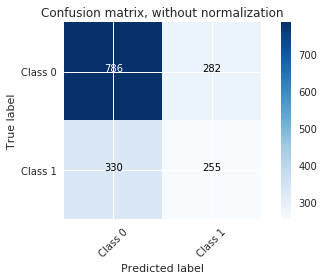

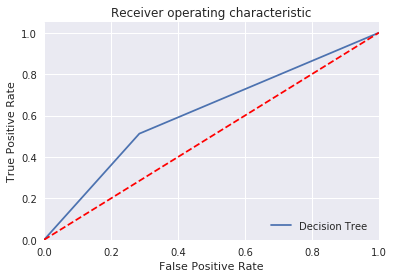

In [44]:


if DT_flag:
    # Decision Tree Model

    DT = DecisionTreeClassifier(random_state=42)
    DT.fit(x_train, y_train)
    cross_val_score(DT, x_train, y_train, cv=3, scoring="accuracy")
    y_test_pred_DT = cross_val_predict(DT, x_test, y_test, cv=3)
    predictions = DT.predict(x_test)
    score = DT.score(x_test, y_test)
    y_test_pred = y_test_pred_DT
    print("DT Accuracy",accuracy_score(y_test, y_test_pred))
    roc = roc_auc_score(y_test, y_test_pred)
    print("roc score", roc)
    DT_CR = classification_report(y_test, y_test_pred)
    print("Classification Report")
    print("="*50)
    print(DT_CR)
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
 
    
 
    
    roc_auc = roc_auc_score(y_test_pred, DT.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, DT.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Decision Tree '  )
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
     
    plt.show()   


RF Accuracy 0.6938898971566848
roc score 0.6421228272351869
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.82      0.78      1068
           1       0.58      0.46      0.52       585

   micro avg       0.69      0.69      0.69      1653
   macro avg       0.66      0.64      0.65      1653
weighted avg       0.68      0.69      0.68      1653

Confusion matrix, without normalization
[[875 193]
 [313 272]]


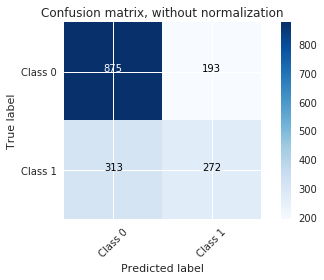

NameError: name 'sgd_clf' is not defined

In [45]:



if RF_flag:
    # Ensemble Random Forest Model

    RF = RandomForestClassifier(random_state=42, n_estimators=100)
    RF.fit(x_train, y_train)
    cross_val_score(RF, x_train, y_train, cv=3, scoring="accuracy")
    y_test_pred_RF = cross_val_predict(RF, x_test, y_test, cv=3)
    predictions = RF.predict(x_test)
    score = RF.score(x_test, y_test)
    y_test_pred = y_test_pred_RF
    print("RF Accuracy",accuracy_score(y_test, y_test_pred))
    roc = roc_auc_score(y_test, y_test_pred)
    print("roc score", roc)
    RF_CR = classification_report(y_test, y_test_pred)
    print("Classification Report")
    print("="*50)
    print(RF_CR)
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
 
    roc_auc = roc_auc_score(y_test_pred, sgd_clf.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, sgd_clf.predict_proba(x_test)[:,1])
 
    
    
    roc_auc = roc_auc_score(y_test_pred, RF.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, RF.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest ' )
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
     
    plt.show()




GB Accuracy 0.7186932849364791
roc score 0.6632502640929607
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1068
           1       0.64      0.47      0.54       585

   micro avg       0.72      0.72      0.72      1653
   macro avg       0.69      0.66      0.67      1653
weighted avg       0.71      0.72      0.71      1653

Confusion matrix, without normalization
[[911 157]
 [308 277]]


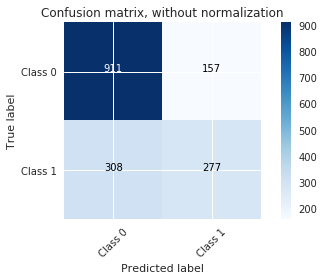

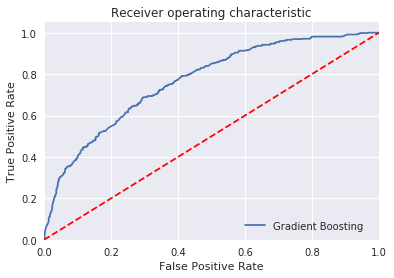

In [46]:

if GB_flag:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
    gb_clf.fit(x_train, y_train)

    cross_val_score(gb_clf, x_train, y_train, cv=3, scoring="accuracy")
    y_test_pred_gb = cross_val_predict(gb_clf, x_test, y_test, cv=3)
    predictions = gb_clf.predict(x_test)
    score = gb_clf.score(x_test, y_test)
    y_test_pred = y_test_pred_gb
    print("GB Accuracy",accuracy_score(y_test, y_test_pred))
    roc = roc_auc_score(y_test, y_test_pred)
    print("roc score", roc)
    GB_CR = classification_report(y_test, y_test_pred)
    print("Classification Report")
    print("="*50)
    print(GB_CR)
    
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
    roc_auc  = auc(fpr , tpr )
 
 
    roc_auc = roc_auc_score(y_test_pred, gb_clf.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, gb_clf.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Gradient Boosting  '  )
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
     
    plt.show()


NN Accuracy 0.6521476104053237
roc score 0.5495198309805052
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.90      0.77      1068
           1       0.52      0.20      0.29       585

   micro avg       0.65      0.65      0.65      1653
   macro avg       0.60      0.55      0.53      1653
weighted avg       0.62      0.65      0.60      1653

Confusion matrix, without normalization
[[962 106]
 [469 116]]


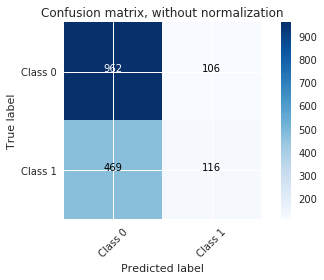

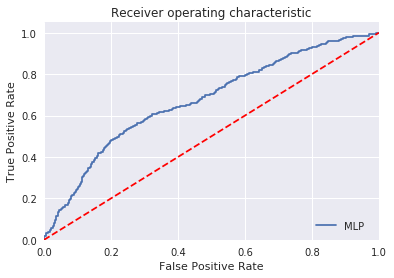

In [47]:
if NN_flag:


    mlp = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
    mlp.fit(x_test, y_test)

    cross_val_score(mlp, x_train, y_train, cv=3, scoring="accuracy")

    y_test_pred_NN = cross_val_predict(mlp, x_test, y_test, cv=3)
    predictions = mlp.predict(x_test)
    score = mlp.score(x_test, y_test)

    y_test_pred = y_test_pred_NN
    print("NN Accuracy",accuracy_score(y_test, y_test_pred))
    roc = roc_auc_score(y_test, y_test_pred)
    print("roc score", roc)
    NN_CR = classification_report(y_test, y_test_pred)
    print("Classification Report")
    print("="*50)
    print(NN_CR)
    
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                          title='Confusion matrix, without normalization')

    # Compute micro-average ROC curve and ROC area
    fpr, tpr, thrsehold = roc_curve(y_test , y_test_pred)
    roc_auc  = auc(fpr , tpr )
  
 
    
     
    roc_auc = roc_auc_score(y_test_pred, mlp.predict(x_test))
    fpr, tpr, thresholds = roc_curve(y_test, mlp.predict_proba(x_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='MLP  '  )
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

Below will display classification report of respective models.

In [50]:
report_list = [LR_CR,SVM_CR,DT_CR,RF_CR,GB_CR,NN_CR]
model_list = ['LR','SVM','DT','RF','GB','NN']
def display_report(model,report):
    display(Markdown(model+" **Model Classification Report** \n"))
    print('\n',report)
    
for (model,report) in zip(model_list, report_list):
    display_report(model,report)
  

LR **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.69      0.89      0.78      1068
           1       0.57      0.27      0.36       585

   micro avg       0.67      0.67      0.67      1653
   macro avg       0.63      0.58      0.57      1653
weighted avg       0.65      0.67      0.63      1653



SVM **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.66      0.70      0.68      1068
           1       0.37      0.33      0.35       585

   micro avg       0.57      0.57      0.57      1653
   macro avg       0.52      0.51      0.51      1653
weighted avg       0.56      0.57      0.56      1653



DT **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.70      0.74      0.72      1068
           1       0.47      0.44      0.45       585

   micro avg       0.63      0.63      0.63      1653
   macro avg       0.59      0.59      0.59      1653
weighted avg       0.62      0.63      0.63      1653



RF **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.74      0.82      0.78      1068
           1       0.58      0.46      0.52       585

   micro avg       0.69      0.69      0.69      1653
   macro avg       0.66      0.64      0.65      1653
weighted avg       0.68      0.69      0.68      1653



GB **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.75      0.85      0.80      1068
           1       0.64      0.47      0.54       585

   micro avg       0.72      0.72      0.72      1653
   macro avg       0.69      0.66      0.67      1653
weighted avg       0.71      0.72      0.71      1653



NN **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.67      0.90      0.77      1068
           1       0.52      0.20      0.29       585

   micro avg       0.65      0.65      0.65      1653
   macro avg       0.60      0.55      0.53      1653
weighted avg       0.62      0.65      0.60      1653



# Question
Based on **Precision, Recall and F1 metrics**, which **model** do you think best fit our prediction?

**Now run 2005 data against your identified model.**

# Model Test

Run below code to review **2005 data.**

In [ ]:
df_2005.head(30)

Select X_train and Y_train data based on selected feature in feature selection box. You can review your selection by clicking below link.

<a href='#feature selection'>**Link to the feature selection box**</a>

In [51]:
if feature_premiere_wide:
    X_train = df_2005[['rating', 'ratingCount', 'runtimeMinutes','premiere','wide']]
elif feature_premiere:
    X_train = df_2005[['rating', 'ratingCount', 'runtimeMinutes','premiere' ]]
elif feature_wide:
    X_train = df_2005[['rating', 'ratingCount',  'runtimeMinutes' ,'wide']]
else :
    X_train = df_2005[['rating', 'ratingCount',  'runtimeMinutes']]


Y_train = df_2005['nomination_winner']

if normalize_flag:
    X_train=(StandardScaler().fit_transform(X_train ))

Split the dataset into training and test data sets.

In [52]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=0)

**Run the selected model** Copy the code from the best determined model box in the previous step, and paste it into the box below.